# Sistem Rekomendasi Film

- Nama : Ahmad Raihan
- Email : ahmadraihan154@gmail.com

## A. Business Understanding
Sistem rekomendasi film memiliki peran penting dalam meningkatkan kenyamanan pengguna saat mencari film yang sesuai dengan selera mereka. Dari sisi bisnis, memahami kebutuhan pengguna secara mendalam serta bagaimana sistem dapat memberikan solusi yang tepat menjadi faktor krusial. Seiring dengan meningkatnya jumlah konten film yang tersedia di berbagai platform streaming, banyak pengguna merasa kewalahan saat harus menentukan film mana yang ingin mereka tonton. Kondisi ini mempertegas pentingnya kehadiran sistem rekomendasi yang andal untuk menyaring dan menyarankan film berdasarkan preferensi personal pengguna.

## B. Data Understanting

## 1. Import Library

In [ ]:
# Library umum
import shutil
import os
import zipfile
from ast import literal_eval
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# Library Visualisasi dan analisis Data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

# Library deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Library pemrosesan dan metrik
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## 2. Data Loading

In [ ]:
# Download dataset
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")
for roots, dirs, files in os.walk(path):
  print(f'Jumlah file adalah {len(files)}')
  print(f'Nama filenya adalah {files}\n')

# Menyimpan data dalam variabel
movies = pd.read_csv(os.path.join(path, "movies_metadata.csv"))
credits = pd.read_csv(os.path.join(path, "credits.csv"))
keywords = pd.read_csv(os.path.join(path, "keywords.csv"))
ratings = pd.read_csv(os.path.join(path, "ratings.csv"))
ratings_small = pd.read_csv(os.path.join(path, "ratings_small.csv"))
links_small = pd.read_csv(os.path.join(path, "links_small.csv"))
links = pd.read_csv(os.path.join(path, "links.csv"))

Jumlah file adalah 7
Nama filenya adalah ['ratings.csv', 'links_small.csv', 'credits.csv', 'keywords.csv', 'movies_metadata.csv', 'ratings_small.csv', 'links.csv']



In [ ]:
print(f'Jumlah data movies adalah --> {movies["id"].nunique()}')

print('-'*80)

print(f'Jumlah data rating keseluruhan --> {len(ratings)}')
print(f'Jumlah pengguna yang memberikan rating ke film --> {ratings["userId"].nunique()}')
print(f'Jumlah film yang memiliki rating --> {ratings["movieId"].nunique()}')

print('-'*80)

print(f'Jumlah data rating_small keseluruhan --> {len(ratings_small)}')
print(f'Jumlah pengguna yang memberikan rating ke film --> {ratings_small["userId"].nunique()}')
print(f'Jumlah film yang memiliki rating --> {ratings_small["movieId"].nunique()}')

print('-'*80)

print(f'Jumlah data links dari imdb dan tmdb dari masing-masing movie   --> {len(links)}')
print(f'Jumlah data links_small dari imdb dan tmdb dari masing-masing movie  --> {len(links_small)}')

print('-'*80)

print(f'Jumlag data pemain dan kru --> {len(credits)}')
print(f'Jumlag data keywords --> {len(keywords)}')

Jumlah data movies adalah --> 45436
--------------------------------------------------------------------------------
Jumlah data rating keseluruhan --> 26024289
Jumlah pengguna yang memberikan rating ke film --> 270896
Jumlah film yang memiliki rating --> 45115
--------------------------------------------------------------------------------
Jumlah data rating_small keseluruhan --> 100004
Jumlah pengguna yang memberikan rating ke film --> 671
Jumlah film yang memiliki rating --> 9066
--------------------------------------------------------------------------------
Jumlah data links dari imdb dan tmdb dari masing-masing movie   --> 45843
Jumlah data links_small dari imdb dan tmdb dari masing-masing movie  --> 9125
--------------------------------------------------------------------------------
Jumlag data pemain dan kru --> 45476
Jumlag data keywords --> 46419


## 3. Exploratory Data Analysis (EDA)

- Dalam tahap Exploratory Data Analysis (EDA) ini, saya hanya akan menggunakan **dua dataset utama**, yaitu **movies** dan **ratings**, untuk menganalisis distribusi film, rating, serta memahami hubungan antar fitur dalam dataset.

- Dataset ratings sendiri, saya hanya akan menggunakan **ratings_small** untuk membangun model sistem rekomendasi karena komputer saya memiliki keterbatasan dalam hal memori dan daya komputasi. Dataset ratings_small sudah cukup mewakili data yang diperlukan untuk eksperimen awal dan pengujian model rekomendasi dengan skala yang lebih kecil.

- Dataset lain seperti **credits**, **keywords**, dan **links** tidak digunakan dalam tahap ini karena tidak terlalu diperlukan untuk pembuatan sistem rekomendasi content-based dan collaborative filtering.

### a. Deskripsi Variabel

- File Movies

In [ ]:
movies.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

Berdasarkan gambar di atas, variabel `movies` terdiri dari **45.466 baris** dan **24 kolom**, dengan penjelasan masing-masing kolom sebagai berikut:

| **Variabel**                | **Keterangan** |
|----------------------------|----------------|
| `adult`                    | Menandakan apakah film mengandung konten dewasa. Biasanya bernilai `True` atau `False`. |
| `belongs_to_collection`    | Menunjukkan apakah film termasuk dalam suatu seri atau koleksi tertentu, seperti franchise film. Biasanya berbentuk string atau format JSON. |
| `budget`                   | Total anggaran produksi film, umumnya dalam satuan dolar AS (USD). |
| `genres`                   | Daftar genre yang dimiliki film, misalnya Action, Drama, atau Comedy. Tersedia dalam bentuk list atau JSON. |
| `homepage`                 | Tautan ke situs web resmi film. |
| `id`                       | ID unik film di dalam sistem database (seperti TMDb). |
| `imdb_id`                  | ID khusus film pada database IMDb. |
| `original_language`       | Kode bahasa asli film, mengikuti format ISO 639-1 (contoh: `en` untuk Bahasa Inggris). |
| `original_title`          | Judul asli film sesuai dengan versi bahasa produksinya. |
| `overview`                | Ringkasan atau sinopsis singkat mengenai cerita film. |
| `popularity`              | Skor popularitas film yang dihitung berdasarkan sistem tertentu dari platform. |
| `poster_path`             | Path atau lokasi file gambar poster film, biasanya digunakan bersama URL dasar untuk mengakses gambar. |
| `production_companies`    | Informasi tentang studio atau perusahaan yang memproduksi film, biasanya berupa daftar dalam format JSON. |
| `production_countries`    | Negara tempat film diproduksi, tersedia dalam format JSON yang berisi nama dan kode negara. |
| `release_date`            | Tanggal film dirilis, dengan format `YYYY-MM-DD`. |
| `revenue`                 | Pendapatan kotor yang dihasilkan film, biasanya dalam USD. |
| `runtime`                 | Durasi total film dalam satuan menit. |
| `spoken_languages`        | Bahasa yang digunakan dalam percakapan film, dicatat dalam format JSON. |
| `status`                  | Status distribusi film, seperti `Released` atau `In Production`. |
| `tagline`                 | Slogan atau kutipan promosi yang terkait dengan film. |
| `title`                   | Judul utama film yang umum digunakan untuk distribusi atau promosi. |
| `video`                   | Menunjukkan apakah film memiliki video tambahan terkait. Nilainya berupa `True` atau `False`. |
| `vote_average`            | Rata-rata skor atau penilaian yang diberikan oleh pengguna (misalnya IMDb atau TMDb) terhadap film, biasanya dalam skala 1–10. |
| `vote_count`              | Jumlah total suara atau penilaian yang diterima oleh film. |


- File Rating (Subset dari rating lengkap)

In [ ]:
ratings_small.head(2)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [ ]:
ratings_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Berdasarkan gambar di atas, variabel `ratings_small` terdiri dari subset rating lengkap yaitu **100.003 baris** dan **4 kolom**, dengan penjelasan masing-masing kolom sebagai berikut:

| **Variabel**   | **Keterangan** |
|----------------|----------------|
| `userId`       | Merupakan identitas unik yang diberikan kepada setiap pengguna yang memberikan rating. Digunakan untuk membedakan antar pengguna secara anonim. |
| `movieId`      | Kode unik yang mewakili setiap film yang dinilai oleh pengguna. ID ini dapat digunakan untuk mengakses informasi lebih lengkap tentang film tersebut. |
| `rating`       | Skor atau nilai evaluasi yang diberikan pengguna terhadap sebuah film, biasanya dalam skala 1 sampai 5. Semakin tinggi nilainya, semakin positif penilaian pengguna. |
| `timestamp`    | Menunjukkan kapan rating diberikan. |



- Insight:

  - Ditemukan **ketidaksesuaian tipe data pada kolom id di dataframe movies, yang bertipe object, sedangkan kolom movieId di ratings_small bertipe int64.**

  - **Penyesuaian tipe data ini penting dilakukan agar proses join antar dataframe dapat berjalan dengan benar**, terutama karena kedua dataframe akan digabung untuk **membangun sistem rekomendasi film** berdasarkan data rating pengguna.

### b. Menghitung total data dari dataset movies dan ratings

In [ ]:
print(f'Jumlah movies adalah --> {movies["id"].nunique()}')
print(f'Jumlah rating adalah --> {len(ratings_small)}')
print(f'Jumlah pengguna yang memberikan rating adalah --> {ratings_small["userId"].nunique()}')
print(f'Jumlah film yang memiliki rating adalah --> {ratings_small["movieId"].nunique()}')

Jumlah movies adalah --> 45436
Jumlah rating adalah --> 100004
Jumlah pengguna yang memberikan rating adalah --> 671
Jumlah film yang memiliki rating adalah --> 9066


- Dari hasil diatas terdapat 45.436 film pada dataset movies, 9066 film yang memiliki rating dan 671 pengguna yang berikan rating pada dataset ratings_small

### c. Melihat Informasi statistik dari dataset movies dan ratings

In [ ]:
movies.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
revenue,45460.0,1.120935e+07,6.433225e+07,0.0,0.0,0.0,0.0,2.787965e+09
runtime,45203.0,9.412820e+01,3.840781e+01,0.0,85.0,95.0,107.0,1.256000e+03
vote_average,45460.0,5.618207e+00,1.924216e+00,0.0,5.0,6.0,6.8,1.000000e+01
vote_count,45460.0,1.098973e+02,4.913104e+02,0.0,3.0,10.0,34.0,1.407500e+04


- Insight:
  - Revenue memiliki nilai yang sangat besar namun terdapat film dengan revenue 0, yang menunjukkan adanya film dengan pendapatan yang tidak tercatat atau film dengan anggaran kecil.

  - Runtime film bervariasi dari sangat pendek (0 menit, mungkin film yang belum selesai atau data yang tidak tercatat) hingga lebih dari 1.200 menit, yang menunjukkan beberapa film dengan durasi sangat panjang.

  - Vote Average menunjukkan rata-rata rating film, yang dimulai dari 0 dengan  berkisar antara 5 hingga 7, lalu nilai tertinggi 10.

  - Vote Count menunjukkan banyaknya ulasan yang diterima film. Banyak film yang memiliki jumlah suara rendah (bahkan ada film yang memiliki jumlah suara 0), namun ada beberapa film yang mendapatkan ribuan ulasan.

In [ ]:
ratings_small.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
userId,100004.0,3.470113e+02,1.951638e+02,1.0,182.0,3.670000e+02,5.200000e+02,6.710000e+02
movieId,100004.0,1.254866e+04,2.636920e+04,1.0,1028.0,2.406500e+03,5.418000e+03,1.639490e+05
rating,100004.0,3.543608e+00,1.058064e+00,0.5,3.0,4.000000e+00,4.000000e+00,5.000000e+00
timestamp,100004.0,1.129639e+09,1.916858e+08,789652009.0,965847824.0,1.110422e+09,1.296192e+09,1.476641e+09


- Insight:

    - UserId menunjukkan distribusi pengguna yang memberikan rating.

    - MovieId menunjukkan bahwa film yang dinilai/memiliki rating.

    - Rating menunjukkan bahwa sebagian besar rating yang diberikan adalah 3 hingga 5.

    - Timestamp menunjukkan waktu ketika rating diberikan. Nilai timestamp yang tinggi menunjukkan data yang lebih baru, sementara nilai timestamp yang lebih rendah menunjukkan data yang lebih lama. Timestamp dicatat dalam bentuk waktu UNIX.

### d. Melihat Distribusi Rating Film

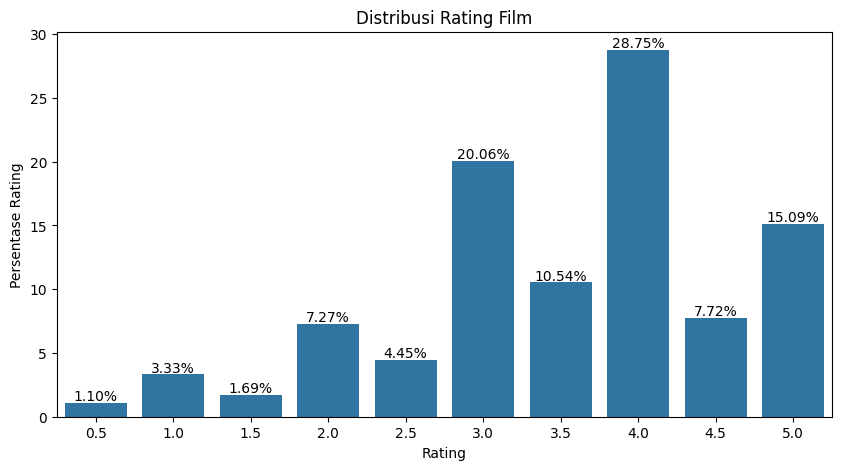

In [ ]:
# Persiapan data untuk rating dalam persen
count_rating = ratings_small.groupby('rating')['userId'].count()
count_rarting_percentage = count_rating/len(ratings_small) * 100

# Membuat barplot distribusi ratinh
plt.figure(figsize=(10,5))
ax = sns.barplot(x=count_rating.index, y=count_rarting_percentage)

# Menampilkan teks
for p in ax.patches:
  plt.text(p.get_x() + p.get_width()/2., p.get_height()+0.5, f'{p.get_height():.2f}%', ha='center', va='center')

# Menampilkan elemen lainnya seperti axis dan judul grafik
plt.title('Distribusi Rating Film')
plt.xlabel('Rating')
plt.ylabel('Persentase Rating')
plt.show()

- Insight :
  - Rating 4 merupakan rating yang paling banyak diberikan oleh pengguna, dengan persentase tertinggi sebesar 28.75%. Ini menunjukkan bahwa sebagian besar pengguna cenderung memberikan penilaian positif terhadap film yang mereka tonton.
  - Disusul oleh rating 3 (20.06%) dan rating 5 (15.09%), menunjukkan bahwa sebagian besar film dinilai berada dalam kategori biasa hingga sangat baik.

  - Rating 0.5 hanya diberikan oleh 1.10% pengguna, menandakan bahwa hanya sedikit film yang dianggap sangat buruk oleh penonton.

### e. Melihat Distribusi Genre dalam Film

In [ ]:
movies.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


- Dari data film yang tersedia, terlihat bahwa genre masih terikat dalam bentuk ID. Oleh karena itu, perlu dilakukan pemetaan ID ke nama genre agar dapat mengetahui genre dari masing-masing film secara eksplisit.

Distribusi Genre : 
genres
Drama                                    20265
Comedy                                   13182
Thriller                                  7624
Romance                                   6735
Action                                    6596
Horror                                    4673
Crime                                     4307
Documentary                               3932
Adventure                                 3496
Science Fiction                           3049
Family                                    2770
Mystery                                   2467
Fantasy                                   2313
Animation                                 1935
Foreign                                   1622
Music                                     1598
History                                   1398
War                                       1323
Western                                   1042
TV Movie                                   767
Carousel Productions             

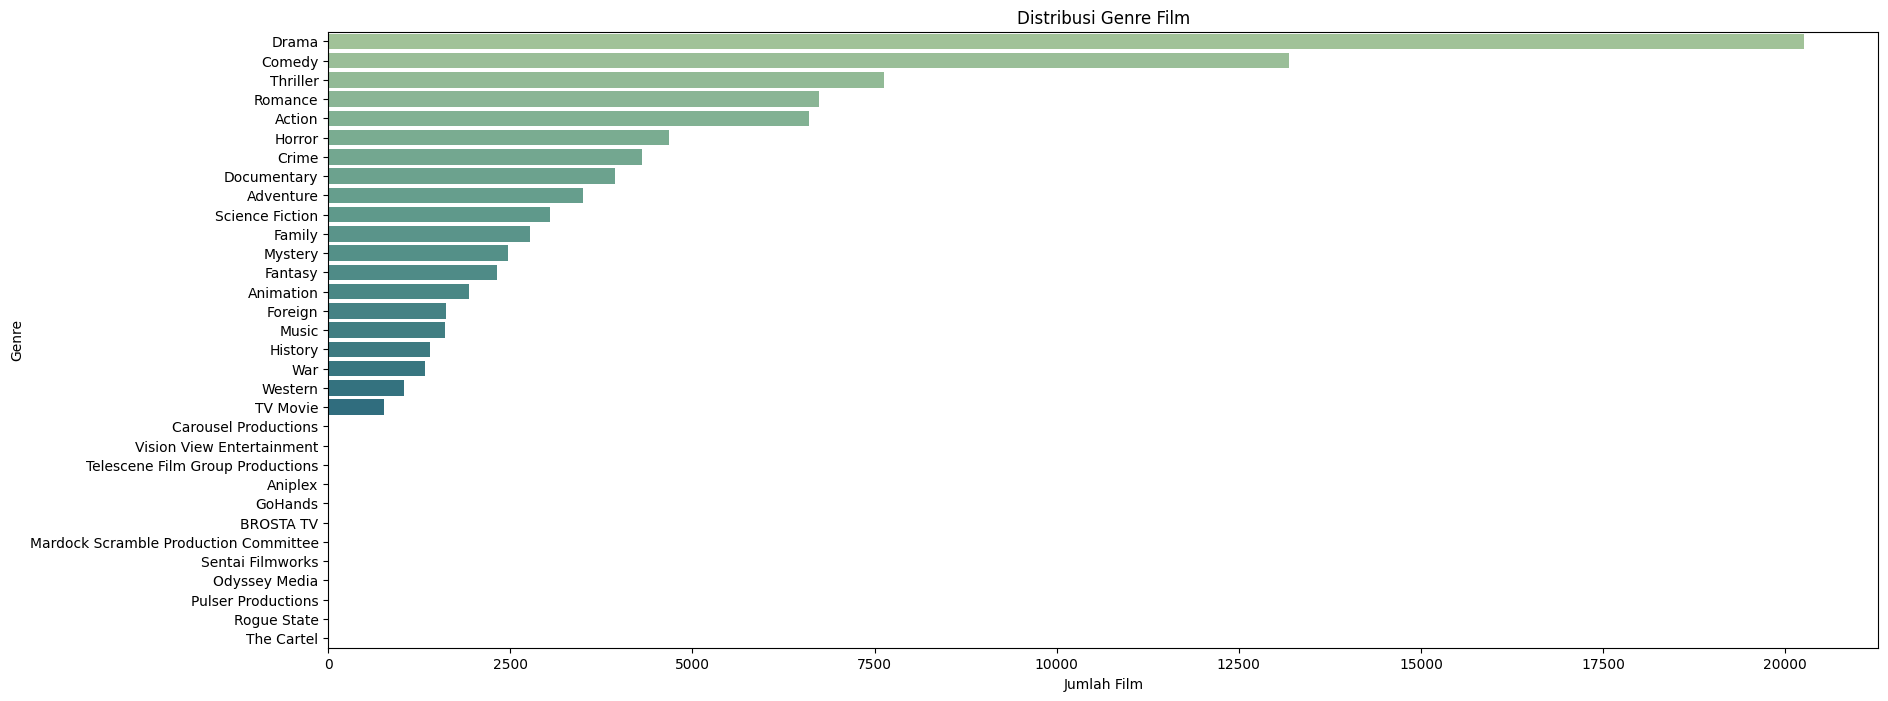

In [ ]:
# Copy data movies ke variabel lain
df_movies = movies.copy()

# Pisahkan genre movie yang awalnya berbentuk dictionary ke baris terpisah
df_movies['genres'] = df_movies['genres'].apply(lambda x: literal_eval(x) if pd.notnull(x) else [])
df_movies['genres'] = df_movies['genres'].apply(lambda x: [i['name'] for i in x] if len(x)>0 else [])
df_exploded = df_movies.explode('genres')

# Menampikan distribusi genre
genre_distribution = df_exploded['genres'].value_counts()
print('Distribusi Genre : ')
print(genre_distribution)

# Membuat grafik barchar untuk menampilkan distribusi genrenya
plt.figure(figsize=(20,8))
ax = sns.barplot(y=genre_distribution.index, x=genre_distribution.values, palette='crest')
plt.title('Distribusi Genre Film')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.show()

- Insight:
  - Genre Drama menjadi genre yang paling sering muncul dengan lebih dari 20.000 kemunculan pada film, diikuti oleh Comedy sekitar 13.000. Ini menunjukkan bahwa banyak film mengandung unsur cerita emosional dan humor, dua genre yang populer di kalangan penonton.
  
  - Perlu dicatat bahwa satu film bisa memiliki lebih dari satu genre. Oleh karena itu, angka ini tidak menunjukkan jumlah film unik, melainkan jumlah total kemunculan genre dalam seluruh dataset film.

  - Beberapa "genre" seperti Carousel Productions, Aniplex, dan lainnya sebenarnya bukan genre, melainkan nama perusahaan produksi. Ini kemungkinan besar disebabkan oleh data yang belum dibersihkan atau salah kategorisasi. Ini menjadi sinyal bahwa perlu dilakukan data cleaning untuk memisahkan genre dari entitas lainnya seperti studio atau produser.


### f. Analisis Rating dan Vote dari Masing-Masing Film

In [ ]:
# Copy data movie untuk analisis
movies_copy = movies.copy()

# Saring id dari movie yang hanya berupa angka
movies_copy = movies_copy[movies_copy['id'].apply(lambda x: x.isnumeric())]

# Konversi id movie dari object ke int
movies_copy['id'] = movies_copy['id'].astype('int')

# Ubah nama kolom id ke movieId agar bisa melakukan join dengan dataframe rating
movies_copy = movies_copy.rename(columns={'id':'movieId'})

# Join ke dataframe untuk mencari movie yang telah diberikan rating
movie_ratings = pd.merge(left=movies_copy, right=ratings_small, on='movieId', how='inner')

# Kelompokkan berdasarkan judul movie lalu urutkan berdasarkan jumlah vote terbanyak
df_movie_rating = movie_ratings.groupby('title').agg(
    user_rating_mean =('rating', 'mean'),
    tmdb_imdb_mean_rating = ('vote_average', 'mean'),
    total_vote = ('vote_count', 'count'))

df_movie_rating = df_movie_rating.sort_values(by='total_vote', ascending=False)

# Top 10 film dengan jumlah vote terbanyak
df_movie_rating.head(10)

,user_rating_mean,tmdb_imdb_mean_rating,total_vote
title,,,
Terminator 3: Rise of the Machines,4.256173,5.900000,324
The Million Dollar Hotel,4.487138,5.900000,311
Solaris,4.134426,7.694098,305
The 39 Steps,4.221649,7.400000,291
Monsoon Wedding,3.706204,6.800000,274
Once Were Warriors,4.303279,7.600000,244
Three Colors: Red,3.945175,7.800000,228
Men in Black II,4.256696,6.100000,224
The Passion of Joan of Arc,3.483945,8.200000,218


- Insight:
  - Berdasarkan 10 film dengan total vote terbanyak:
    - "Terminator 3: Rise of the Machines" menjadi film dengan jumlah vote terbanyak (324 vote). Film ini mendapatkan mean rating 4.26 dari pengguna, serta vote average 5.9 dari TMDb/imdb.

    - Terdapat perbedaan rating antara user_rating dan tmdb/imdb rating pada beberapa film, seperti "The Million Dollar Hotel" (user rating 4.48 vs tmdb/imdb rating 5.9) dan "The Passion of Joan of Arc" (user rating 3.48 vs tmdb/imdb rating 8.2), yang menunjukkan perbedaan preferensi antara komunitas user_rating dan tmdb/imdb rating.

  

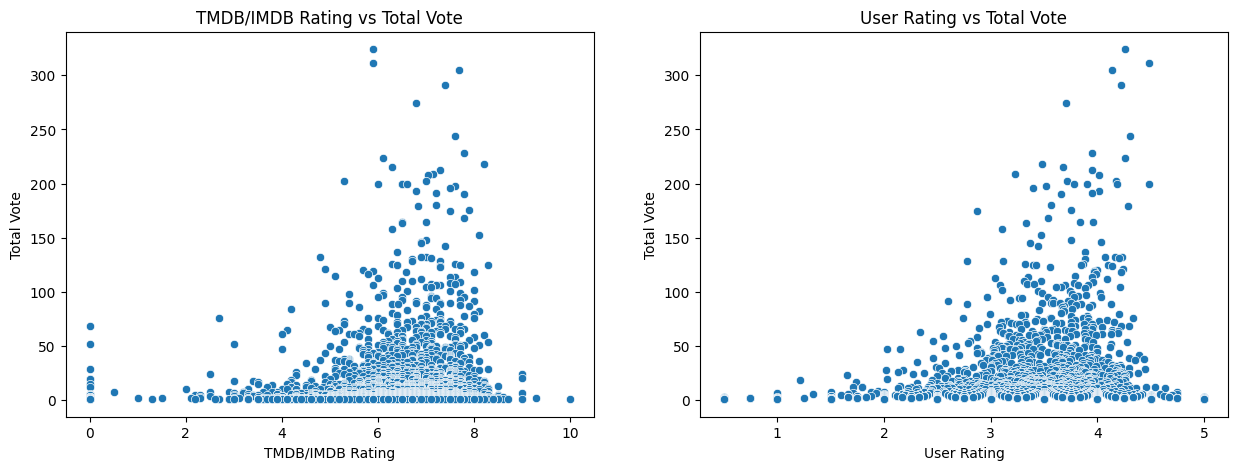

In [ ]:
# Membuat scatterplot untuk melihat hubungan antara rating dan total vote

fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(data=df_movie_rating, x='tmdb_imdb_mean_rating', y='total_vote', ax=ax[0])
ax[0].set(title='TMDB/IMDB Rating vs Total Vote',
          xlabel='TMDB/IMDB Rating',
          ylabel='Total Vote')

sns.scatterplot(data=df_movie_rating, x='user_rating_mean', y='total_vote', ax=ax[1])
ax[1].set(title='User Rating vs Total Vote',
          xlabel='User Rating',
          ylabel='Total Vote')
plt.show()

- Insight:
  - Dari kedua grafik, terlihat bahwa film dengan rating menengah hingga tinggi (sekitar 6–8 di TMDB/IMDB dan 3–4 di user rating) cenderung mendapatkan jumlah vote yang lebih banyak.

  - Sedangkan film dengan rating sangat rendah atau sangat tinggi cenderung memiliki jumlah vote yang lebih sedikit dimana ini bisa terjadi karena film tersebut kurang populer atau hanya menarik bagi segmen tertentu.

  - Meskipun rentang rating TMDb/IMDb lebih luas (0–10) dan user rating lebih sempit (0-5), keduanya memperlihatkan tren serupa: film dengan rating ekstrem (terlalu rendah atau terlalu tinggi) justru cenderung mendapatkan vote lebih sedikit dibandingkan film dengan rating moderat.

## C. Data Preparation

## 1. Tahapan Data Preparation Umum
- Pada tahapan ini, dilakukan proses persiapan data sebelum masuk ke tahap pemodelan sistem rekomendasi.

- Tahapan ini bersifat umum dan diperlukan baik untuk pendekatan Content-Based Filtering maupun Collaborative Filtering, karena keduanya memerlukan data yang bersih, relevan, dan terstruktur agar menghasilkan rekomendasi yang akurat dan optimal.

### a. Pemilihan Fitur yang Relevan
- pada tahap ini, hanya beberapa fitur yang relevan untuk membangun sistem rekomendasi yang akan diambil yaitu **id, genres, dan title dari dataframe movies**.

- Pada dataframe ratings_small, .semua fitur akan digunakan kecuali **timestamp yang perlu dihapus**.

In [ ]:
# Mengambil fitur yang relevan
df_movies = movies[['id','genres', 'title']]
df_movies.head()

,id,genres,title
0,862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story
1,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji
2,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men
3,31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Waiting to Exhale
4,11862,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II


In [ ]:
df_ratings = ratings_small.drop(columns='timestamp')
df_ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


### b. Penyesuaian Nama dan Tipe Data
- Dari hasil pengecekan EDA, perlu dilakukan **penyesuaian tipe data pada kolom id di dataframe movies agar konsisten dengan tipe data int64 pada kolom movieId di dataframe ratings_small**.
- Setelah penyesuaian tipe data, nama kolom id pada dataframe movies perlu diubah menjadi movieId agar dapat melakukan join antar dataframe dengan benar

In [ ]:
# Pertama, pastikan id hanya berisi angka (numerik) dan filter nilai yang valid
df_movies = df_movies[df_movies['id'].apply(lambda x: x.isnumeric())]

# Ubah tipe data id menjadi int64
df_movies['id'] = df_movies['id'].astype('int64')

# Ganti nama kolom 'id' menjadi 'movieId'
df_movies = df_movies.rename(columns={'id': 'movieId'})

df_movies.head()

,movieId,genres,title
0,862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story
1,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji
2,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men
3,31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Waiting to Exhale
4,11862,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II


### c. Mengonversi Fitur Genre menjadi Format yang Terstruktur
- Pada tahap ini, dilakukanlah **pengubahan format kolom genres yang berisi data dalam bentuk list of dictionaries** menjadi format yang lebih terstruktur, seperti list of genre names agar lebih mudah dalam analisis dan pemrosesan lebih lanjut.

- Selanjutnya, **list kosong pada kolom genres diubah menjadi NaN** agar baris-baris yang tidak memiliki genre dapat dengan mudah diidentifikasi dan dihapus saat diperlukan. Langkah ini membantu meminimalkan gangguan dari data yang tidak relevan dalam analisis.

- Hal ini bertujuan untuk mempermudah pemanfaatan data genre dalam model rekomendasi.

In [ ]:
# Mengubah string yang berbentuk list of dictionaries (jika ada) menjadi objek list menggunakan literal_eval
df_movies['genres'] = df_movies['genres'].apply(lambda x: literal_eval(x) if pd.notnull(x) else np.nan)

# Mengambil nama genre dari setiap dictionary di dalam list 'genres'.
# Jika list kosong, ubah menjadi NaN
df_movies['genres'] = df_movies['genres'].apply(lambda x: [i['name'] for i in x] if len(x) > 0 else np.nan)

# Menampilkan 5 baris pertama untuk memeriksa hasil
df_movies.head()

,movieId,genres,title
0,862,"[Animation, Comedy, Family]",Toy Story
1,8844,"[Adventure, Fantasy, Family]",Jumanji
2,15602,"[Romance, Comedy]",Grumpier Old Men
3,31357,"[Comedy, Drama, Romance]",Waiting to Exhale
4,11862,[Comedy],Father of the Bride Part II


### d. Menggabungkan dataframe movies dan ratings_small
- Pada tahap ini, setelah dilakukan penyesuaian pada DataFrame movies dan ratings_small maka dilakukan penggabungan antara DataFrame movies dan ratings_small.

- Tujuan dari penggabungan ini adalah untuk mengaitkan setiap film dengan rating yang diberikan oleh pengguna, sehingga informasi mengenai rating film dapat disertakan dalam analisis lebih lanjut.

In [ ]:
# Menggabungkan dataframe
df_movies_ratings = pd.merge(left=df_movies, right=df_ratings, on='movieId', how='inner')
df_movies_ratings.head()

,movieId,genres,title,userId,rating
0,949,"[Action, Crime, Drama, Thriller]",Heat,23,3.5
1,949,"[Action, Crime, Drama, Thriller]",Heat,102,4.0
2,949,"[Action, Crime, Drama, Thriller]",Heat,232,2.0
3,949,"[Action, Crime, Drama, Thriller]",Heat,242,5.0
4,949,"[Action, Crime, Drama, Thriller]",Heat,263,3.0


### e. Mengatasi Nilai yang missing
- Dari tahapan sebelumnya, yaitu pengubahan fitur genre menjadi list of genre names, terdapat beberapa nilai yang missing (kosong) pada kolom tersebut. Hal ini terjadi karena beberapa film mungkin tidak memiliki genre yang tercantum dalam data atau ada data yang tidak lengkap.

- Penanganan nilai missing dilakukan dengan cara menghapusnya sehingga  memastikan kualitas data yang digunakan dalam analisis dan pembangunan model baik.

In [ ]:
# Hapus nilai yang missing
df_movies_ratings = df_movies_ratings.dropna()

df_final = df_movies_ratings.copy()

## 2. Tahapan Data Preparation untuk Content-Based Filtering
- Content-based filtering adalah metode yang digunakan dalam sistem rekomendasi yang berfokus pada karakteristik atau konten dari item-item yang ingin direkomendasikan atau dianalisis.

- Pada tahapan ini, data yang telah dipersiapkan pada tahapan umum akan difokuskan untuk mengolah informasi dari sisi konten film guna mengukur kemiripan antar film dan memberikan rekomendasi yang relevan.

In [ ]:
preparation_cb = df_final.copy()
preparation_cb

,movieId,genres,title,userId,rating
0,949,"[Action, Crime, Drama, Thriller]",Heat,23,3.5
1,949,"[Action, Crime, Drama, Thriller]",Heat,102,4.0
2,949,"[Action, Crime, Drama, Thriller]",Heat,232,2.0
3,949,"[Action, Crime, Drama, Thriller]",Heat,242,5.0
4,949,"[Action, Crime, Drama, Thriller]",Heat,263,3.0
...,...,...,...,...,...
44989,64197,"[Romance, Drama]",Travelling with Pets,73,4.0
44990,64197,"[Romance, Drama]",Travelling with Pets,544,5.0
44991,64197,"[Romance, Drama]",Travelling with Pets,648,3.5
44992,98604,"[Comedy, Romance]",Cinderella,352,4.0


- Dari pengecekan data diatas terlihat ada 44.792 baris dan 5 kolom

### a. Mengatasi Data yang Duplikat
- Dari hasil penggabungan, terlihat bahwa terdapat beberapa data yang duplikat. Duplikasi ini terjadi karena setiap pengguna dapat memberikan rating pada film yang sama, sehingga menghasilkan baris yang berulang dengan movieId yang sama, tetapi dengan userId dan rating yang berbeda.

- Untuk memastikan data yang digunakan dalam content-based filtering adalah data unik, perlu dilakukan penghapusan duplikasi menggunakan fungsi drop_duplicates().

In [ ]:
preparation_cb = preparation_cb.drop_duplicates(subset=['movieId'])
preparation_cb

,movieId,genres,title,userId,rating
0,949,"[Action, Crime, Drama, Thriller]",Heat,23,3.5
16,710,"[Adventure, Action, Thriller]",GoldenEye,358,1.0
18,1408,"[Action, Adventure]",Cutthroat Island,7,1.0
61,524,"[Drama, Crime]",Casino,8,2.0
97,4584,"[Drama, Romance]",Sense and Sensibility,293,5.0
...,...,...,...,...,...
44956,80831,[Drama],Sang Pemimpi,48,2.5
44960,3104,"[Horror, Science Fiction]",Frankenstein Created Woman,4,4.0
44989,64197,"[Romance, Drama]",Travelling with Pets,73,4.0
44992,98604,"[Comedy, Romance]",Cinderella,352,4.0


### b. Pemilihan Fitur yang Relevan
- **Dikarenakan Content-Based Filtering hanya berfokus pada karakteristik dari item (dalam hal ini film)**, maka dipilihkan fitur-fitur yang relevan adalah informasi yang menggambarkan konten film itu sendiri, seperti **movieid, judul, dan genre yang dapat mewakili isi dari film**.

- Fitur seperti userId dan rating tidak diperlukan pada tahap ini, karena pendekatan content-based tidak mempertimbangkan interaksi antar pengguna.

In [ ]:
preparation_cb.drop(columns=['userId', 'rating'], inplace=True)
preparation_cb

,movieId,genres,title
0,949,"[Action, Crime, Drama, Thriller]",Heat
16,710,"[Adventure, Action, Thriller]",GoldenEye
18,1408,"[Action, Adventure]",Cutthroat Island
61,524,"[Drama, Crime]",Casino
97,4584,"[Drama, Romance]",Sense and Sensibility
...,...,...,...
44956,80831,[Drama],Sang Pemimpi
44960,3104,"[Horror, Science Fiction]",Frankenstein Created Woman
44989,64197,"[Romance, Drama]",Travelling with Pets
44992,98604,"[Comedy, Romance]",Cinderella


### c. Ekstraksi Fitur Teks dari Kolom Genre
- Tahap ini menggunakan teknik TF-IDF (Term Frequency - Inverse Document Frequency) untuk mengubah isi kolom genres menjadi representasi numerik berbasis teks. Representasi ini memungkinkan sistem mengenali kemiripan antar film berdasarkan informasi genre.

- Sebelum menerapkan TfidfVectorizer, data pada kolom genres perlu dikonversi dari list menjadi string, karena TfidfVectorizer hanya dapat memproses input dalam bentuk teks.

In [ ]:
data = preparation_cb.copy().reset_index(drop=True)

# Konversi list menjadi string
data['genres'] = data['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

In [ ]:
# Inisiasi objek TF-IDF Vectorizer dari sklearn
vectorizer = TfidfVectorizer()

# Transformasi teks genre menjadi matriks TF-IDF
tf_idf_matrix = vectorizer.fit_transform(data['genres'])

# Menampilkan fitur/genre unik yang dihasilkan oleh TF-IDF setelah proses token
vectorizer.get_feature_names_out()

array(['action', 'adventure', 'animation', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'fantasy', 'fiction', 'foreign',
       'history', 'horror', 'movie', 'music', 'mystery', 'romance',
       'science', 'thriller', 'tv', 'war', 'western'], dtype=object)

In [ ]:
# Cek shape dari matriks tf_idfnya
tf_idf_matrix.shape

(2800, 22)

In [ ]:
# Masukkan hasil dari matrix ke dalam dataframe

pd.DataFrame(
    tf_idf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=data['title']
)

,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,fiction,...,horror,movie,music,mystery,romance,science,thriller,tv,war,western
title,,,,,,,,,,,,,,,,,,,,,
Heat,0.544462,0.000000,0.0,0.000000,0.58990,0.0,0.329909,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.496729,0.0,0.0,0.0
GoldenEye,0.561910,0.649193,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.512646,0.0,0.0,0.0
Cutthroat Island,0.654449,0.756106,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
Casino,0.000000,0.000000,0.0,0.000000,0.87278,0.0,0.488113,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
Sense and Sensibility,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.516092,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.856533,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sang Pemimpi,0.000000,0.000000,0.0,0.000000,0.00000,0.0,1.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
Frankenstein Created Woman,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.568436,...,0.594778,0.0,0.0,0.0,0.000000,0.568436,0.000000,0.0,0.0,0.0
Travelling with Pets,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.516092,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.856533,0.000000,0.000000,0.0,0.0,0.0


## 3. Tahapan Data Preparation untuk Collaborative Filtering
- Collaborative Filtering adalah metode dalam sistem rekomendasi yang memberikan rekomendasi berdasarkan interaksi atau preferensi pengguna lain yang memiliki pola kesukaan serupa, tanpa mempertimbangkan konten atau atribut dari item itu sendiri.

- Pada tahapan ini, data yang telah dipersiapkan pada tahapan umum akan difokuskan untuk mengolah informasi dari interaksi pengguna terhadap item, seperti rating atau penilaian terhadap film, guna mengukur kemiripan antar pengguna atau antar item berdasarkan perilaku pengguna.

In [ ]:
preparation_cf = df_final.copy()
preparation_cf

,movieId,genres,title,userId,rating
0,949,"[Action, Crime, Drama, Thriller]",Heat,23,3.5
1,949,"[Action, Crime, Drama, Thriller]",Heat,102,4.0
2,949,"[Action, Crime, Drama, Thriller]",Heat,232,2.0
3,949,"[Action, Crime, Drama, Thriller]",Heat,242,5.0
4,949,"[Action, Crime, Drama, Thriller]",Heat,263,3.0
...,...,...,...,...,...
44989,64197,"[Romance, Drama]",Travelling with Pets,73,4.0
44990,64197,"[Romance, Drama]",Travelling with Pets,544,5.0
44991,64197,"[Romance, Drama]",Travelling with Pets,648,3.5
44992,98604,"[Comedy, Romance]",Cinderella,352,4.0


- Dari pengecekan data diatas terlihat ada 44.792 baris dan 5 kolom

### a. Pemilihan Fitur yang Relevan
- **Dikarenakan Collaborative Filtering berfokus pada pola interaksi pengguna terhadap item, maka fitur yang dipilih adalah userId, movieId, dan rating** yang merepresentasikan hubungan antara pengguna dan item (film).

- Fitur-fitur seperti genre atau judul film tidak diperlukan dalam tahap ini, karena pendekatan collaborative tidak menggunakan informasi konten dari item, melainkan hanya berdasarkan pola perilaku pengguna.

In [ ]:
# Pilihlah fitur yang relevan untuk collaborative filtering
preparation_cf = preparation_cf[['userId', 'movieId', 'rating']]

# urutkan datanya berdasarkan userId
preparation_cf = preparation_cf.sort_values(by='userId')
preparation_cf

,userId,movieId,rating
11376,1,2105,4.0
13727,1,2193,2.0
10561,1,1371,2.5
27973,1,1405,1.0
31731,1,2455,2.5
...,...,...,...
10934,671,1641,4.0
39480,671,4880,4.0
39060,671,1673,3.5
43084,671,457,4.0


### b. Melakukan Encoding UserId dan movieId
- Karena model deep learning hanya bisa bekerja dengan angka, maka kolom userId dan movieId harus diubah ke bentuk numerik terurut (jika belum).

In [ ]:
# Inisiasi LabelEncoder untuk mengonversi userId dan movieId menjadi format numerik
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

# Gunakan LabelEncoder untuk mengonversi userId dan movieId ke dalam label numerik
preparation_cf['user'] = user_encoder.fit_transform(preparation_cf['userId'])
preparation_cf['movie'] = movie_encoder.fit_transform(preparation_cf['movieId'])


# Tampilkan Jumlah pengguna, Jumlah film, Minimum rating, dan Maksimum rating
print(f'Jumlah dari pengguna --> {preparation_cf["user"].nunique()}')
print(f'Jumlah dari movie --> {preparation_cf["movie"].nunique()}')
print(f'Rating minimum --> {preparation_cf["rating"].min()}')
print(f'Rating maksimum --> {preparation_cf["rating"].max()}\n')

# Tampilkan data yang telah diencoding untuk melihat hasilnya
preparation_cf.head()

Jumlah dari pengguna --> 671
Jumlah dari movie --> 2800
Rating minimum --> 0.5
Rating maksimum --> 5.0



,userId,movieId,rating,user,movie
11376,1,2105,4.0,0,1071
13727,1,2193,2.0,0,1121
10561,1,1371,2.5,0,704
27973,1,1405,1.0,0,725
31731,1,2455,2.5,0,1201


- Dapat dilihat hasilnya, data ini memiliki 671 user, 2800 movie dan rating minimim 0.5 dan rating maksimum 5.0

### c. Normalisasi Data
- Karena pendekatan **Collaborative Filtering** berfokus pada pola interaksi antara pengguna dan item (film), penting untuk melakukan **normalisasi data** sebelum melatih model. Normalisasi membantu menyamakan skala nilai rating yang diberikan oleh pengguna, sehingga model **deep learning** dapat lebih efektif dalam mendeteksi pola. Dalam hal ini, rating awal yang berada dalam rentang **0 hingga 5** dinormalisasi menjadi skala **0 hingga 1**. Proses ini dilakukan agar model dapat memproses input numerik secara lebih cepat dan efisien saat proses pelatihan model.

In [ ]:
# Normalisasi rating ke rentang 0-1
min_rating = preparation_cf['rating'].min()
max_rating = preparation_cf['rating'].max()

preparation_cf['rating_norm'] = (preparation_cf['rating'] - min_rating) / (max_rating - min_rating)

### d. Pemisahan Data
- Data yang telah dipersiapkan kemudian dipisahkan menjadi tiga subset berdasarkan proporsi yang telah ditentukan, yaitu 80% untuk data pelatihan (training), 10% untuk data validasi (validation), dan 10% untuk data pengujian (testing).

- Pembagian ini dilakukan untuk memastikan model dapat dilatih dengan data yang cukup, diuji dengan data yang belum pernah dilihat, dan dievaluasi dengan data yang terpisah dari proses pelatihan.

In [ ]:
# Memisahkan data menjadi 80% untuk training dan 20% untuk validasi dan testing
train_data, temp_data = train_test_split(preparation_cf, test_size=0.2, random_state=42)

# Memisahkan 20% temp_data menjadi 10% validasi dan 10% testing
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Menampilkan jumlah data untuk memastikan pembagian yang benar
print(f"Jumlah data untuk pelatihan: {len(train_data)}")
print(f"Jumlah data untuk validasi: {len(validation_data)}")
print(f"Jumlah data untuk pengujian: {len(test_data)}")


Jumlah data untuk pelatihan: 35833
Jumlah data untuk validasi: 4479
Jumlah data untuk pengujian: 4480


## D. Modeling and Result

## 1. Content-Based Filtering
- Adapun penjelasan dibawah adalah tahapan dalam membangun sistem rekomendasi content-based filtering dari data yang sudah dipersiapkan sebelumnya

### a. Hitung Similarity antar Film
- Menggunakan Cosine Similarity untuk menghitung seberapa mirip film satu dengan lainnya berdasarkan genre:

In [ ]:
cosine_sim = cosine_similarity(tf_idf_matrix, tf_idf_matrix)
cosine_sim

array([[1.        , 0.56058474, 0.35632279, ..., 0.17026338, 0.        ,
        0.52554876],
       [0.56058474, 1.        , 0.85859993, ..., 0.        , 0.        ,
        0.54239   ],
       [0.35632279, 0.85859993, 1.        , ..., 0.        , 0.        ,
        0.34475772],
       ...,
       [0.17026338, 0.        , 0.        , ..., 1.        , 0.66019714,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.66019714, 1.        ,
        0.        ],
       [0.52554876, 0.54239   , 0.34475772, ..., 0.        , 0.        ,
        1.        ]])

### b. Membuat Mapping antara hasil cosine similarity dan judulnya
- Agar bisa mencari film berdasarkan judul:

In [ ]:
cosine_df = pd.DataFrame(cosine_sim, columns=data['title'], index=data['title'])
cosine_df

title,Heat,GoldenEye,Cutthroat Island,Casino,Sense and Sensibility,Four Rooms,Get Shorty,Leaving Las Vegas,The City of Lost Children,Twelve Monkeys,...,Totò Sceicco,FC Venus,Beat,Jesus,Wolf and Calf,Sang Pemimpi,Frankenstein Created Woman,Travelling with Pets,Cinderella,The One-Man Band
title,,,,,,,,,,,,,,,,,,,,,
Heat,1.000000,0.560585,0.356323,0.675886,0.170263,0.468026,0.665107,0.170263,0.000000,0.193288,...,0.000000,0.000000,0.329909,0.121313,0.0,0.329909,0.0,0.170263,0.000000,0.525549
GoldenEye,0.560585,1.000000,0.858600,0.000000,0.000000,0.000000,0.284784,0.000000,0.307272,0.199482,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.542390
Cutthroat Island,0.356323,0.858600,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.357875,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.344758
Casino,0.675886,0.000000,0.000000,1.000000,0.251912,0.692463,0.575787,0.251912,0.000000,0.000000,...,0.000000,0.000000,0.488113,0.179487,0.0,0.488113,0.0,0.251912,0.000000,0.000000
Sense and Sensibility,0.170263,0.000000,0.000000,0.251912,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.660197,0.516092,0.189776,0.0,0.516092,0.0,1.000000,0.660197,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sang Pemimpi,0.329909,0.000000,0.000000,0.488113,0.516092,0.000000,0.000000,0.516092,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.367717,0.0,1.000000,0.0,0.516092,0.000000,0.000000
Frankenstein Created Woman,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.556205,0.579065,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000
Travelling with Pets,0.170263,0.000000,0.000000,0.251912,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.660197,0.516092,0.189776,0.0,0.516092,0.0,1.000000,0.660197,0.000000


### c. Membangun Fungsi Rekomendasi
- Buat fungsi untuk mengambil rekomendasi berdasarkan input judul film:

In [ ]:
def film_recommendations(nama_film, similarity_data=cosine_sim, items=data[['title', 'genres']], top_n=10):

    # Copy dataframe untuk mencegah perubahan pada data asli
    items = items.copy()

    # Pastikan case yang digunakan untuk pencarian film sama yaitu lower
    items['title_lower'] = items['title'].str.lower()
    nama_film = nama_film.lower()

    # Mencari indeks film yang ada di dalam similarity_data untuk film yang diberikan
    if nama_film not in items['title_lower'].values:
        return f"Film '{nama_film}' tidak ditemukan dalam data."

    film_index = items[items['title_lower'] == nama_film].index[0]

    # Mengambil nilai cosine similarity untuk film yang dicari
    sim_scores = similarity_data[film_index]

    # Mengurutkan berdasarkan similarity, ambil k film teratas (k+1 karena index dimulai dari 0)
    similar_indices = sim_scores.argsort()[-(top_n+1):-1][::-1]

    # Mengambil nama film berdasarkan indeks
    similar_movies = items['title'].iloc[similar_indices]

    # Menampilkan dataframe dengan film yang direkomendasikan
    return pd.DataFrame(similar_movies).merge(items, on='title').head(top_n).drop(columns='title_lower')


### d. Pengujian Sistem Rekomendasi
- Pada tahap ini, akan dilakukanlah pengujian dari sistem yang telah dibuat

In [ ]:
data[data['title'] == 'The Man with the Golden Arm']

,movieId,genres,title
674,541,Crime Drama Romance,The Man with the Golden Arm


In [ ]:
rekomendasi = film_recommendations('the man with the golden arm')
rekomendasi

,title,genres
0,Angel Face,Crime Drama Romance
1,Schizo,Crime Drama Romance
2,The Man with the Golden Arm,Crime Drama Romance
3,Made in Hong Kong,Crime Drama Romance
4,3-Iron,Drama Romance Crime
5,B. Monkey,Romance Crime Drama
6,The Little Thief,Romance Drama Crime
7,Tie Me Up! Tie Me Down!,Comedy Crime Drama Romance
8,Prizzi's Honor,Romance Comedy Crime Drama
9,Match Point,Drama Thriller Crime Romance


- Terlihat beberapa film yang ditampilkan memiliki genre yang sama.

## 2. Collaborative Filtering
- Adapun penjelasan dibawah adalah tahapan dalam membangun sistem rekomendasi content-based filtering dari data yang sudah dipersiapkan sebelumnya

### a. Membangun Arsitektur Model Deep Learning

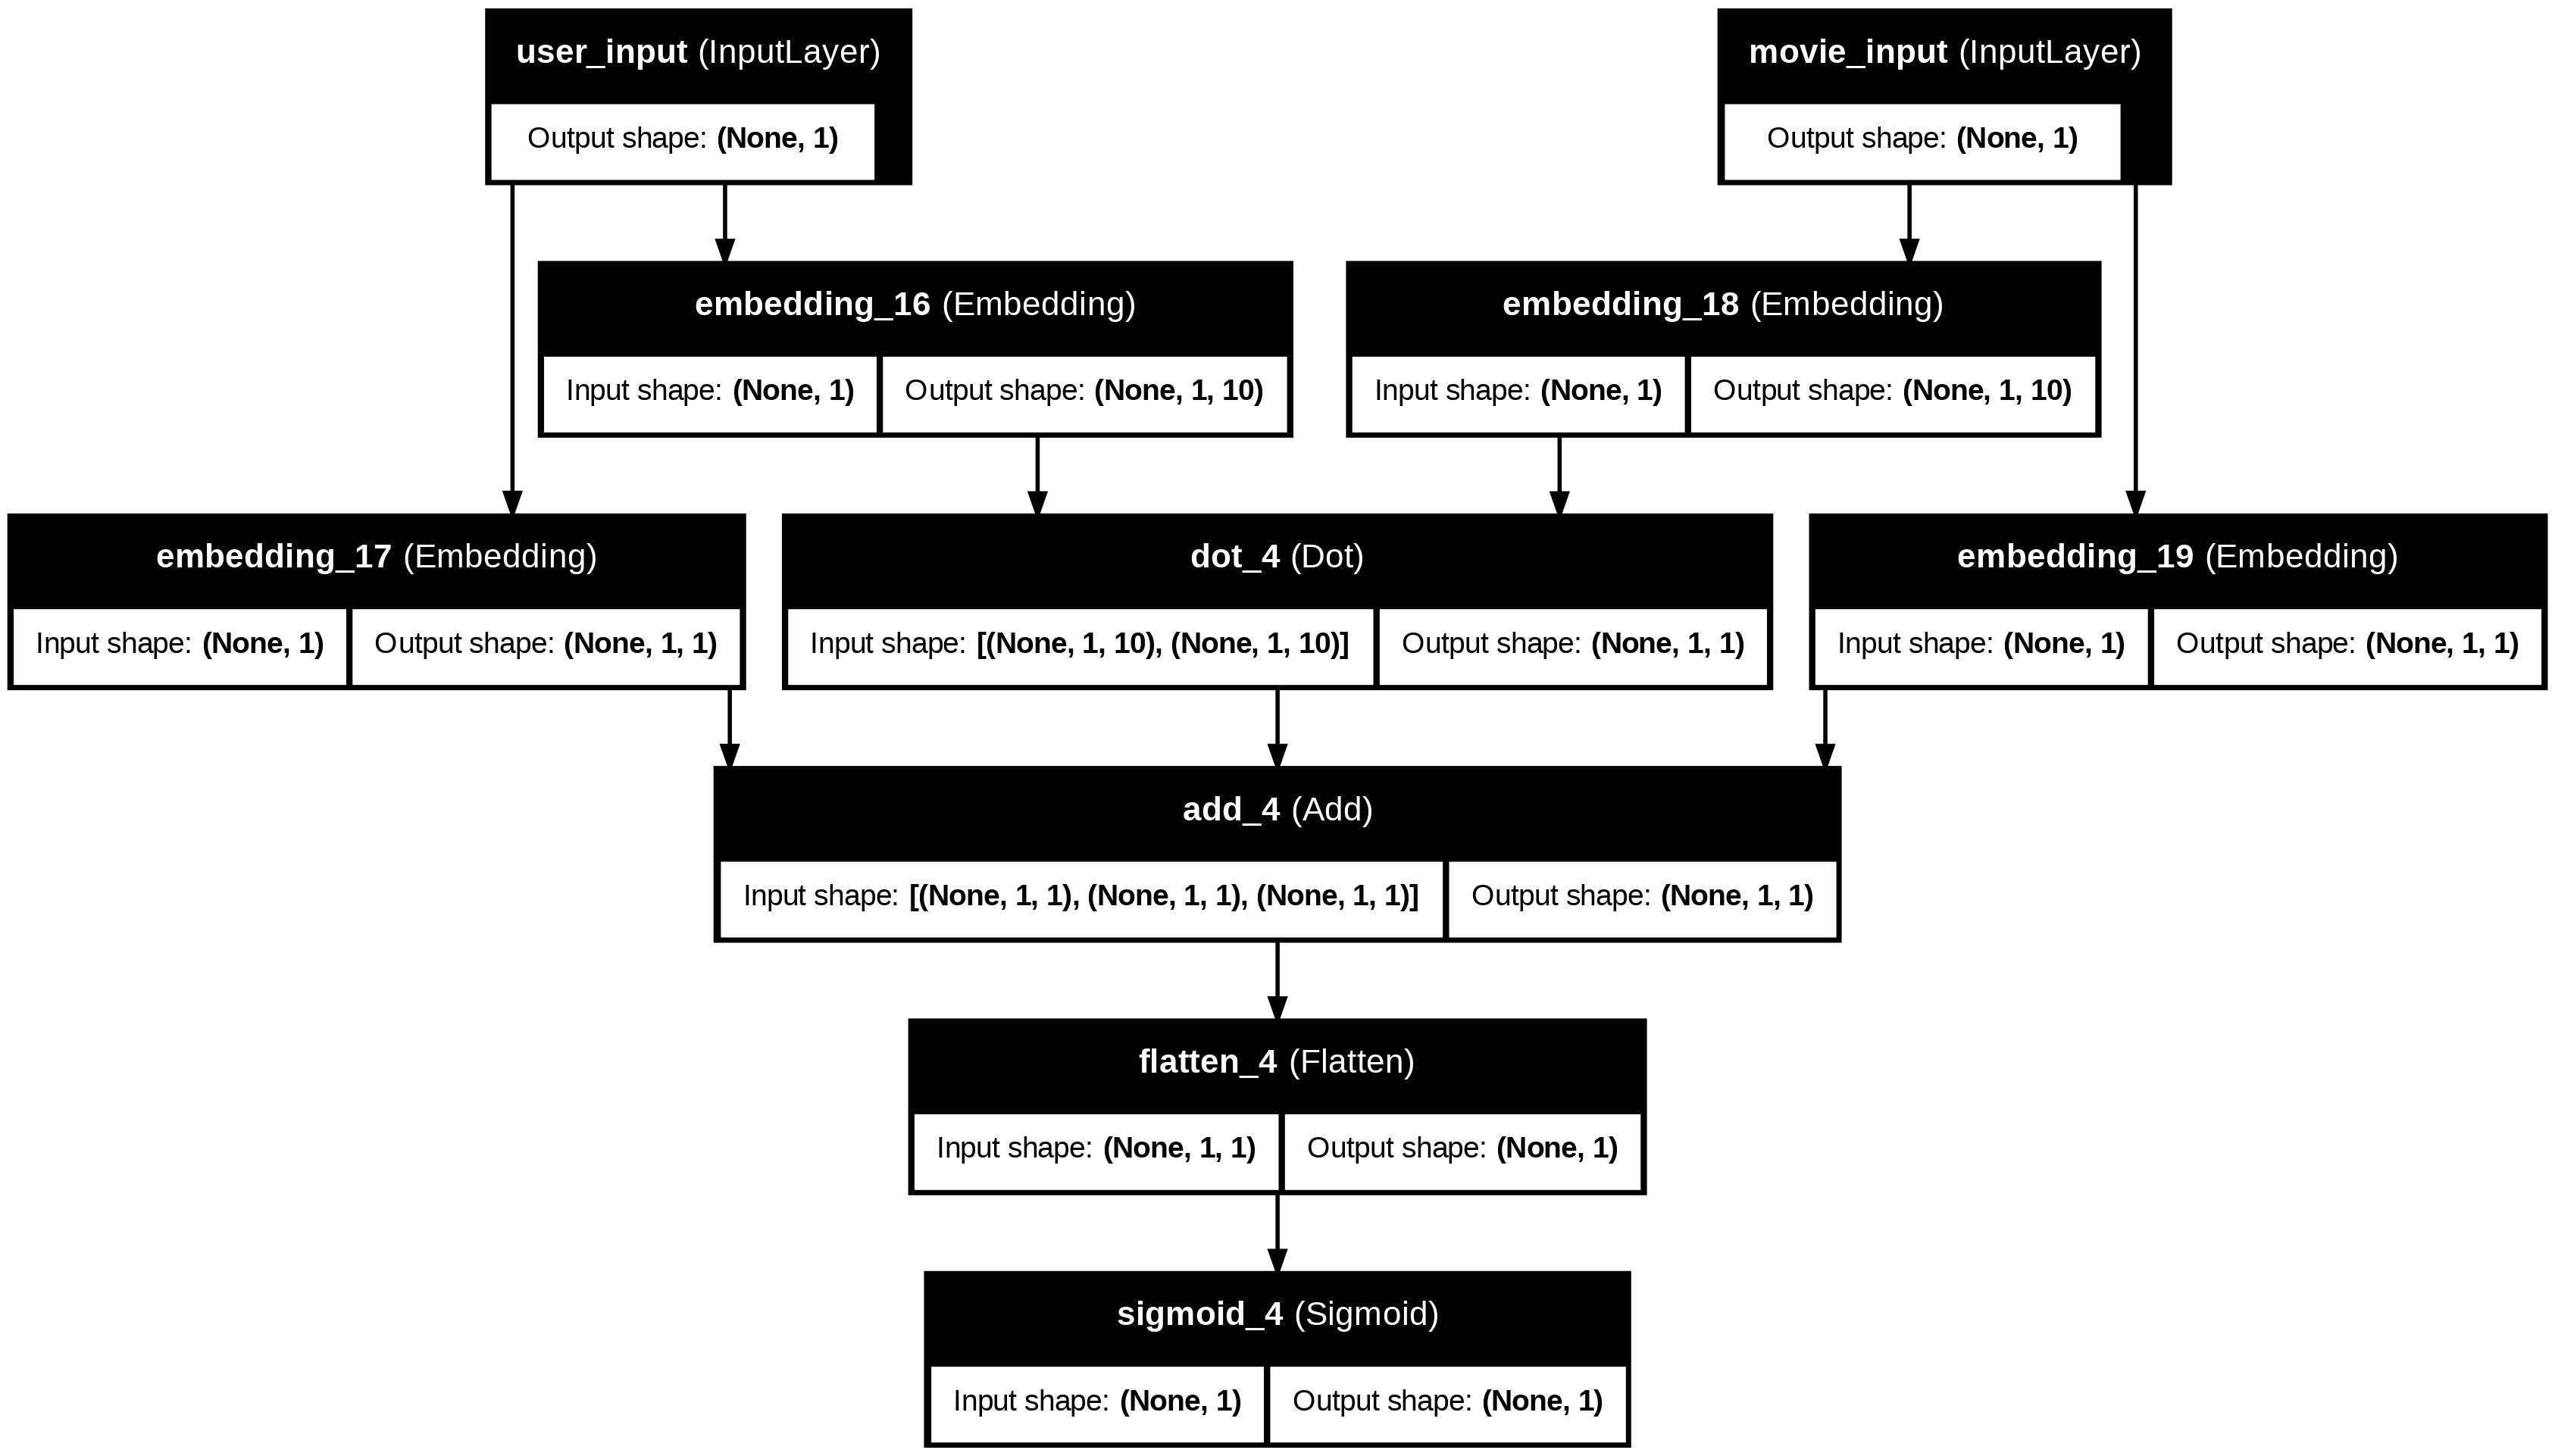

In [ ]:
# Ukuran vektor embedding
embedding_size = 50

# Input untuk user dan movie
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

# Embedding untuk user
user_embedding = Embedding(
    input_dim= preparation_cf['user'].nunique(),
    output_dim=embedding_size,
    embeddings_initializer='he_normal',
    embeddings_regularizer=l2(1e-6)
)(user_input)

# Bias untuk user
user_bias = Embedding(
    input_dim= preparation_cf['user'].nunique(),
    output_dim=1
)(user_input)

# Embedding untuk movie
movie_embedding = Embedding(
    input_dim=preparation_cf['movie'].nunique(),
    output_dim=embedding_size,
    embeddings_initializer='he_normal',
    embeddings_regularizer=l2(1e-6)
)(movie_input)

# Bias untuk movie
movie_bias = Embedding(
    input_dim=preparation_cf['movie'].nunique(),
    output_dim=1
)(movie_input)

# Dot product antara user dan movie embedding
dot_product = Dot(axes=2)([user_embedding, movie_embedding])

# Tambahkan bias user dan movie ke hasil dot product
add_bias = Add()([dot_product, user_bias, movie_bias])

# Flatten output
x = Flatten()(add_bias)

# Aktifkan output dengan sigmoid (karena target sudah dinormalisasi)
output = tf.keras.activations.sigmoid(x)

# Bangun model
model = Model(inputs=[user_input, movie_input], outputs=output)

# Lihat ringkasan model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

### b. Melatih Model

In [ ]:
# Kompilasi model
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mean_absolute_error', "root_mean_squared_error"])

# Pelatihan model
history = model.fit(
    x=[train_data['user'], train_data['movie']],
    y=train_data['rating_norm'],
    batch_size=32,
    epochs=5,
    verbose=1,
    validation_data=([validation_data['user'], validation_data['movie']], validation_data['rating_norm']))

Epoch 1/5
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0798 - mean_absolute_error: 0.2376 - root_mean_squared_error: 0.2824 - val_loss: 0.0618 - val_mean_absolute_error: 0.2056 - val_root_mean_squared_error: 0.2485
Epoch 2/5
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0550 - mean_absolute_error: 0.1915 - root_mean_squared_error: 0.2342 - val_loss: 0.0463 - val_mean_absolute_error: 0.1727 - val_root_mean_squared_error: 0.2145
Epoch 3/5
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0408 - mean_absolute_error: 0.1590 - root_mean_squared_error: 0.2011 - val_loss: 0.0423 - val_mean_absolute_error: 0.1608 - val_root_mean_squared_error: 0.2041
Epoch 4/5
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0361 - mean_absolute_error: 0.1468 - root_mean_squared_error: 0.1883 - val_loss: 0.0408 - val_mean_absolute_error: 0.1560 - val_root_mean_squared_error: 0.2000
Epoch 5/5
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0329 - mean_absolute_error: 0.1381 - root_mea

### c. Menguji Sistem Rekomendasi

In [ ]:
movie_df = df_movies.copy()
df = df_final

# Ambil satu user secara acak
user_id = df['userId'].sample(1).iloc[0]
movie_rated_by_user = df[df['userId']==user_id]

# Film yang belum pernah ditonton user
movies_not_watched = movie_df[~movie_df['movieId'].isin(movie_rated_by_user['movieId'].values)]['movieId']
movies_not_watched = list(
    set(movies_not_watched)
    .intersection(set(movie_encoder.classes_))  # agar cocok dengan movie yang sudah diencode
)

# Encode movie dan user
movies_not_watched_encoded = [[movie_encoder.transform([x])[0]] for x in movies_not_watched]
user_encoded = user_encoder.transform([user_id])[0]

user_input_array = np.array([user_encoded] * len(movies_not_watched_encoded))
movie_input_array = np.array([x[0] for x in movies_not_watched_encoded])

predicted_ratings = model.predict([user_input_array, movie_input_array]).flatten()

# Ambil 10 film dengan rating tertinggi
top_ratings_indices = predicted_ratings.argsort()[-10:][::-1]
recommended_movie_ids = [movies_not_watched[x] for x in top_ratings_indices]

# Tampilkan hasil
print('Showing recommendations for user: {}'.format(user_id))
print('=' * 30)
print('Top 5 Movies the user has rated:')
print('-' * 30)

top_movies_user = (
    movie_rated_by_user.sort_values(by='rating', ascending=False)
    .head(5)
    .movieId.values
)

top_movies_info = movie_df[movie_df['movieId'].isin(top_movies_user)]
for row in top_movies_info.itertuples():
    print(row.title, ':', row.genres)

print('-' * 30)
print('Top 10 Movie Recommendations:')
print('-' * 30)

recommended_movies = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ':', row.genres)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Showing recommendations for user: 294
Top 5 Movies the user has rated:
------------------------------
Bringing Up Baby : ['Comedy', 'Romance']
To Kill a Mockingbird : ['Crime', 'Drama']
Broken Blossoms : ['Drama', 'Romance']
New York Doll : ['Documentary', 'Music']
Silent Hill : ['Horror', 'Mystery']
------------------------------
Top 10 Movie Recommendations:
------------------------------
Beetlejuice : ['Fantasy', 'Comedy']
Notting Hill : ['Romance', 'Comedy', 'Drama']
Under the Sand : ['Drama', 'Mystery']
Nostalgia : ['Drama', 'Romance']
Frankenstein Unbound : ['Drama', 'Horror', 'Science Fiction']
Rocky Balboa : ['Drama']
That Man from Rio : ['Action', 'Adventure', 'Comedy']
My Name Is Bruce : ['Comedy', 'Horror']
Miffo : ['Comedy', 'Drama']
Hacker : ['Comedy']


## E. Evaluation

## 1. Content-Based Filtering

- Evaluasi kinerja sistem rekomendasi dilakukan untuk mengukur seberapa baik sistem dalam memberikan rekomendasi yang relevan dan sesuai dengan kebutuhan pengguna. Adapaun Metrik yang digunakan dalam menilai kinerja sistem rekomendasi content-based adalah Precision.

- Precision mengukur proporsi film yang relevan di antara semua film yang direkomendasikan. Semakin tinggi precision, semakin sedikit film yang tidak relevan yang direkomendasikan. Precision yang tinggi menunjukkan bahwa rekomendasi yang diberikan umumnya tepat sasaran.


In [ ]:
# Daftar genre yang dianggap penting sesuai preferensi
target_genres = {"Crime", "Drama", "Romance"}

# Fungsi untuk mengecek apakah semua genre target ada dalam genre film
def cocok_dengan_preferensi(genre_str):
    film_genres = set(genre_str.split())
    return target_genres.issubset(film_genres)

# Tandai film yang sesuai preferensi genre
rekomendasi['sesuai_genre'] = rekomendasi['genres'].apply(cocok_dengan_preferensi)

# Hitung jumlah film yang benar-benar sesuai (positif relevan)
jumlah_sesuai = rekomendasi['sesuai_genre'].sum()

# Hitung total film yang diberikan sebagai rekomendasi
jumlah_direkomendasikan = rekomendasi.shape[0]

# Precision: proporsi rekomendasi yang sesuai dari semua yang diberikan
presisi = jumlah_sesuai / jumlah_direkomendasikan * 100

# Tampilkan hasil
print(f"Precision: {presisi:.2f}%")
rekomendasi[['title', 'genres', 'sesuai_genre']]

Precision: 100.00%


,title,genres,sesuai_genre
0,Angel Face,Crime Drama Romance,True
1,Schizo,Crime Drama Romance,True
2,The Man with the Golden Arm,Crime Drama Romance,True
3,Made in Hong Kong,Crime Drama Romance,True
4,3-Iron,Drama Romance Crime,True
5,B. Monkey,Romance Crime Drama,True
6,The Little Thief,Romance Drama Crime,True
7,Tie Me Up! Tie Me Down!,Comedy Crime Drama Romance,True
8,Prizzi's Honor,Romance Comedy Crime Drama,True
9,Match Point,Drama Thriller Crime Romance,True


- Insight:
  - Precision: 100.00%
    - Nilai precision yang sangat tinggi menunjukkan bahwa semua film yang direkomendasikan oleh sistem benar-benar relevan dengan preferensi pengguna. Artinya, sistem sangat akurat dalam memberikan rekomendasi, dan tidak ada rekomendasi yang tidak relevan atau salah.

## 2. Collaborative Filtering
- Evaluasi kinerja sistem rekomendasi dilakukan untuk mengukur seberapa baik sistem dalam memberikan rekomendasi yang relevan dan sesuai dengan kebutuhan pengguna. Adapun metrik evaluasi yang digunakan dalam sistem rekomendasi **Collaborative Filtering** adalah **Mean Absolute Error (MAE)** dan **Root Mean Squared Error (RMSE)**.  

- Untuk perhitungannya semakin kecil nilai MAE atau RMSE maka semakin baik kemampuan sistem dalam memprediksi rating pengguna.

In [ ]:
loss, mae, rmse = model.evaluate([test_data['user'], test_data['movie']], test_data['rating_norm'])
print(f'Hasil MAE adalah {mae}')
print(f'Hasil RMSE adalah {rmse}')

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0398 - mean_absolute_error: 0.1530 - root_mean_squared_error: 0.1968
Hasil MAE adalah 0.1533566117286682
Hasil RMSE adalah 0.1971302628517151


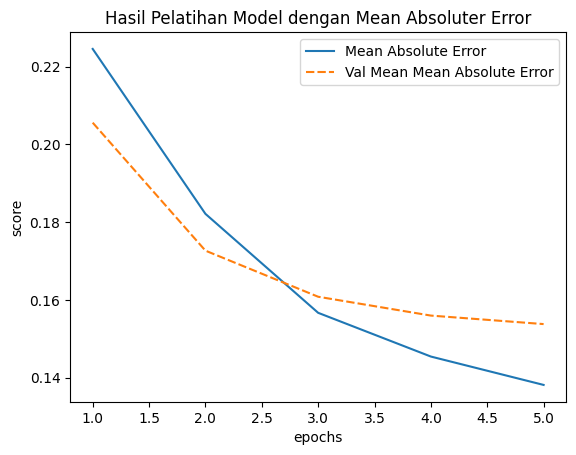

In [ ]:
df_result_mae = pd.DataFrame({'Mean Absolute Error':history.history['mean_absolute_error'],
                          'Val Mean Mean Absolute Error':history.history['val_mean_absolute_error']}, index=range(1,6))

sns.lineplot(data=df_result_mae)
plt.title('Hasil Pelatihan Model dengan Mean Absoluter Error')
plt.xlabel('epochs')
plt.ylabel('score')
plt.show()

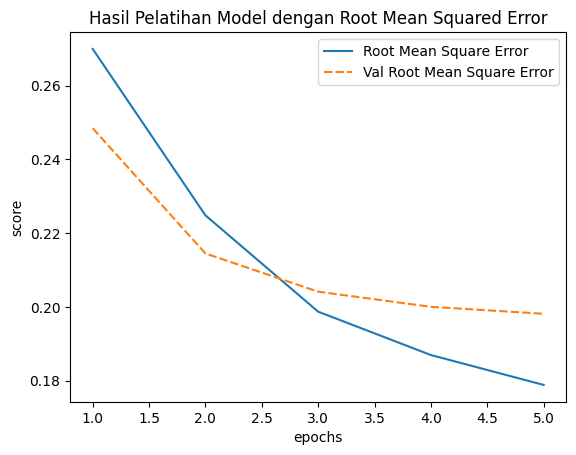

In [ ]:
df_result_val = pd.DataFrame({'Root Mean Square Error':history.history['root_mean_squared_error'],
                          'Val Root Mean Square Error':history.history['val_root_mean_squared_error']}, index=range(1,6))

sns.lineplot(data=df_result_val)

plt.title('Hasil Pelatihan Model dengan Root Mean Squared Error')
plt.xlabel('epochs')
plt.ylabel('score')
plt.show()

Insight:
  - Berdasarkan hasil evaluasi menggunakan metrik Mean Absolute Error (MAE) dan Root Mean Squared Error (RMSE), model menunjukkan performa yang cukup baik. Setelah 5 epoch pelatihan, nilai MAE pada data pelatihan mencapai sekitar 0.138, sedangkan pada data validasi sebesar 0.155. Begitu pula dengan RMSE yang menunjukkan 0.1538 pada data pelatihan dan sekitar 0.20 pada data validasi.

  - Performa ini menunjukkan bahwa model cukup efektif dalam menangkap pola interaksi antara pengguna dan item (film). Error yang rendah berarti rekomendasi yang dihasilkan lebih dekat dengan rating yang seharusnya diberikan oleh pengguna, sehingga meningkatkan relevansi rekomendasi. Hal ini dapat berdampak positif terhadap pengalaman pengguna secara keseluruhan, karena sistem akan lebih sering merekomendasikan film yang sesuai dengan selera pengguna berdasarkan historis interaksinya.